<a href="https://colab.research.google.com/github/krkh-1702/SCI-6485/blob/main/Copy_of_VAE_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

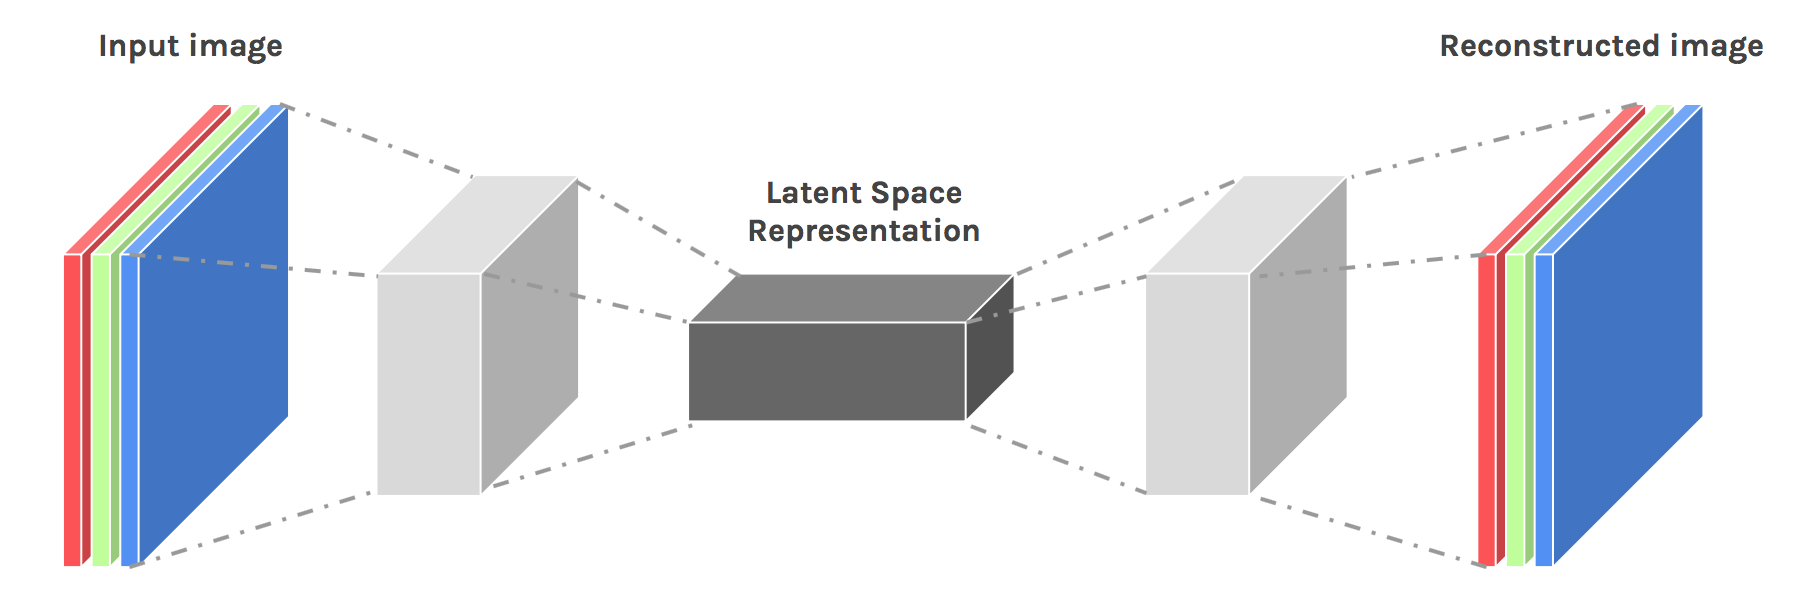

# Variational Autoencoder

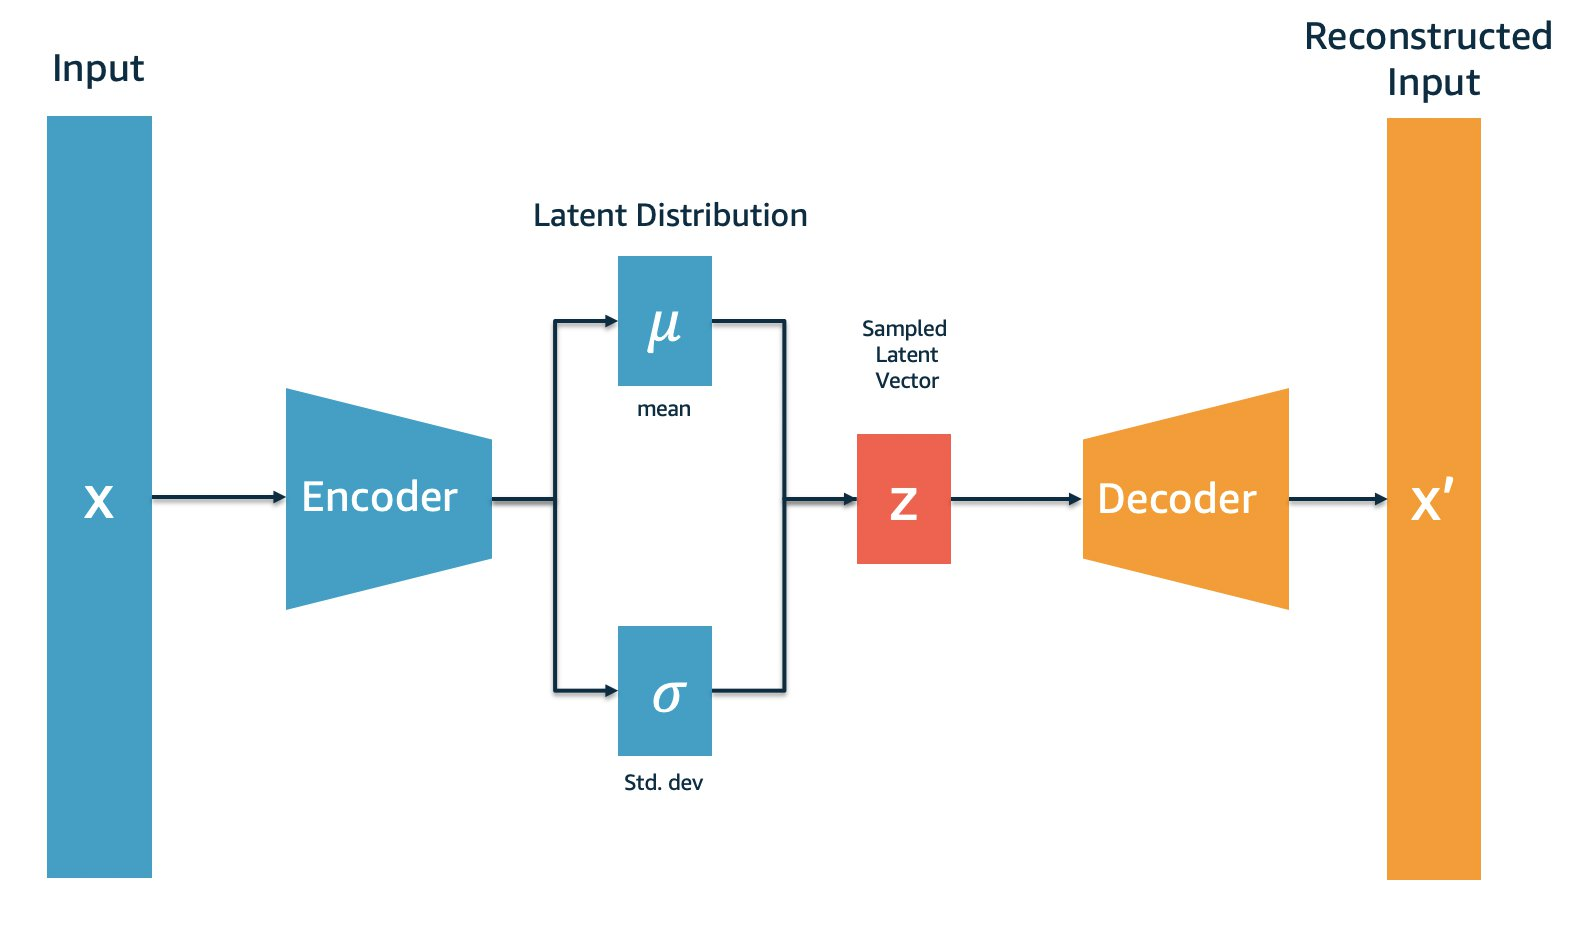


# Main 4 elements of a VAE are:

*   encoder
*   decoder
*   mu
*   sigma


mu, sigma represent the "parameters" for the distributions in this example.

While training we will "learn" these paramaters, (the same way we "learn" our weights using back propagation)

Note: The encoder  is a neural network that DOES NOT GENERATE z. Instead it generates parameters FOR a distribution OVER z.

The encoder network can be any neural network of your choice that encodes, i.e. downsample your data, here we will be using ResNet18.

Resnet18.svg


# VAE Loss
Our goal is to minimize the distance between 2 distributions of images, q and p.

gen_models_diag_2.svg

---
Term 1 = Reconstruction loss ( minimize distance between source and target image, same as autoencoder)

Term 2 = KL divergence (minimize distance between source distribution and target distritbution given here by p and q respectively)

VAE Loss = Reconstuction + KL divergence

This is also known as ELBO (Evidence Lower Bound)

ELBO is given by :


$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$


The first term is the KL-divergence and the second term the reconstruction.


Now that we have a source ($p$) and a target ($q$). We can treat this as an optimization problem where we parametrize $q$ (ie: a neural network) to try to get close to $p$ via gradient descent.

This is called variational inference (in general).

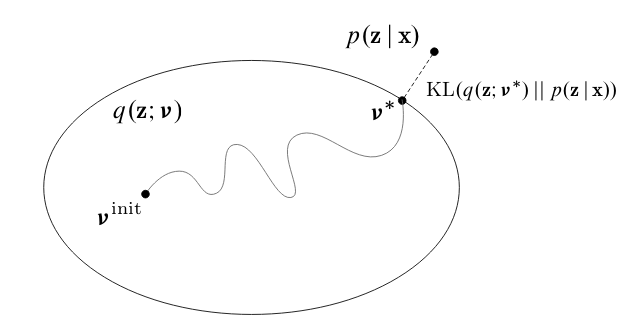

### KL divergence definition

The distance to minimize is called the KL divergence.
When we minimize the KL divergence, our $q$ will be an estimator of $p$.

This is the definition for the KL divergence between two distributions P, Q:

$$
D_{KL}(Q||P) = \sum Q \log \frac{Q}{P}
$$

We'll replace Q, P with our distributions $P = p(z|x)$ and $Q = q(z|x)$
$$
D_{KL}(q(z|x)||p(z|x)) = \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}
$$

So, the end goal is to minimize this function:

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
import torch

q = torch.distributions.Normal(2, 4)

z = q.rsample()
print(z)

tensor(4.6316)


## KL divergence intuition
Here we show the intuition of minimizing the KL

In [ ]:
p = torch.distributions.Normal(0, 1)
q = torch.distributions.Normal(2, 4)

log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)

print('log prob pz: ', log_pz, 'prob:', torch.exp(log_pz))
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

log prob pz:  tensor(-11.6446) prob: tensor(8.7661e-06)
log prob qzx:  tensor(-2.5216) prob: tensor(0.0803)


In [ ]:
kl_divergence = log_qzx - log_pz
kl_divergence

tensor(9.1230)

now, if we manually move q closer to p, we see that this distrance has shrunk. 

In [ ]:
# old q = torch.distributions.Normal(2, 4)
q = torch.distributions.Normal(1, 2)

log_qzx = q.log_prob(z)
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

log prob qzx:  tensor(-3.2606) prob: tensor(0.0384)


new kl

In [ ]:
new_kl_divergence = log_qzx - log_pz
new_kl_divergence

tensor(8.3840)

---
## Implementation walk-through
So, with our formula defined, let's start our implementation.


If you skipped the math and elbo derivation, remember we are implementing this loss (the ELBO)

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

In [ ]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts==0.2.5rc1

In [ ]:
pip install lightning-bolts

     |████████████████████████████████| 316 kB 4.2 MB/s 


In [ ]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

#### Sample z

In Lightning we define the model interactions and the core algorithm in the training_step.

For EDUCATIONAL purposes only, we are adding the training_step to the lightning module here instead of in the original class definition

The VAE algorithm goes like this:

1. Sample z

In [ ]:
vae = VAE()

In [ ]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = torch.rand(1, 3, 32, 32)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

image shape: torch.Size([1, 3, 32, 32])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


In [ ]:
zero = torch.zeros_like(mu)
one = torch.ones_like(std)
p = torch.distributions.Normal(zero, one)

#### decoding

The second part is reconstruction.

The decoder is going to take as input $z$ and it will generate PARAMETERS for a distribution from which to sample a reconstruction.

Note: Most tutorials use MNIST so the decoder generates BERNOULLI variables which can be used in a bernoulli distribution to sample a value for each pixel.

That's right, the decoder generates distribution parameters FOR EACH pixel. And since most tutorials use MNIST the outputs of the decoder will LOOK like a digit because those parameters are in the range 0-1 (which happens to be the same for black and white images).


But in our case, we'll actually use CIFAR-10 which are color images... so we need to do something more realistic:


In [ ]:
x_hat = vae.decoder(z)
print(x_hat.shape)

torch.Size([1, 3, 32, 32])


#### reconstruction loss 

You'll likely see the reconstruction loss using MSE like this in most tutorials about autoencoders.

However, MSE DOES not apply to Variational autoencoders

In [ ]:
recon_loss = F.mse_loss(x_hat, x, reduction='none')
recon_loss = recon_loss.sum(-1).sum(-1).sum(-1)
print('wrong reconstruction loss', recon_loss)

wrong reconstruction loss tensor([4748.7158], grad_fn=<SumBackward1>)


Instead, the output of the decoder represents parameters for a distribution.

When the images are MNIST, the parameters (decoder output) can be considered bernoullis and thus you can use the pixel values of MNIST (because they are ones and zeros) to calculate the cross entropy (which is the "reconstruction loss").

But when dealing with color images, it is prefered to model each parameter out of the decoder as a gaussian.

In [ ]:
# get the PARAMETERS for P(x|z)
x_hat = vae.decoder(z)
print('we have these many parameters for a distribution:', x_hat.shape)

# compute the probability of x under this n-dimensional distribution
log_scale = nn.Parameter(torch.Tensor([0.0]))
scale = torch.exp(log_scale)
dist = torch.distributions.Normal(x_hat, scale)
log_pxz = dist.log_prob(x)

print(log_pxz.shape)

# sum across channels, and all pixels (width, height)
# this gives the log probability of THIS particular IMAGE
log_pxz = log_pxz.sum(dim=(1, 2, 3))
print(log_pxz.shape)
print('reconstruction loss:', log_pxz.item())

recon_loss = log_pxz

we have these many parameters for a distribution: torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1])
reconstruction loss: -5197.33740234375


#### kl divergence

Next we'll define the second term of the loss which is the KL divergence.

Now, we don't want to compute the KL divergence analytically, so we'll instead use the monte carlo estimate.

$$
= \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}\\
= \mathbb{E}_{q} [\log q(z|x) - \log{p(z)}]
$$

To code this, we'll need to be able to get the probability of z under each of $p(z)$ and $q(z|x)$.

This means we don't need to know what the distribution is, but only sample from it.


In [ ]:
# 1. define the first two probabilities (in this case Normal for both)
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
q = torch.distributions.Normal(mu, std)

# 2. get the probabilities from the equation
log_qzx = q.log_prob(z)
log_pz = p.log_prob(z)

print(log_qzx.shape, log_pz.shape)

# 3. calculate the KL
kl = (log_qzx - log_pz)

# 4. this bit is a bit tricky. Since these are log probabilities
# we can sum all the individual dimensions to give us the multi-dimensional
# probability
kl = kl.sum(-1)
print(kl)

torch.Size([1, 256]) torch.Size([1, 256])
tensor([41.6216], grad_fn=<SumBackward1>)


#### ELBO

So, the full elbo is:

In [ ]:
elbo = (kl - recon_loss)
print('kl:', kl.mean())
print('log likelihood (reconstruction loss):', recon_loss.mean())
print('elbo: ', elbo.mean())

kl: tensor(41.6216, grad_fn=<MeanBackward0>)
log likelihood (reconstruction loss): tensor(-5197.3374, grad_fn=<MeanBackward0>)
elbo:  tensor(5238.9590, grad_fn=<MeanBackward0>)


# Full Implementation
So, the full implementation is as follows.

In [ ]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

This example uses  the CIFAR-10 dataset and Lightning Datamodule



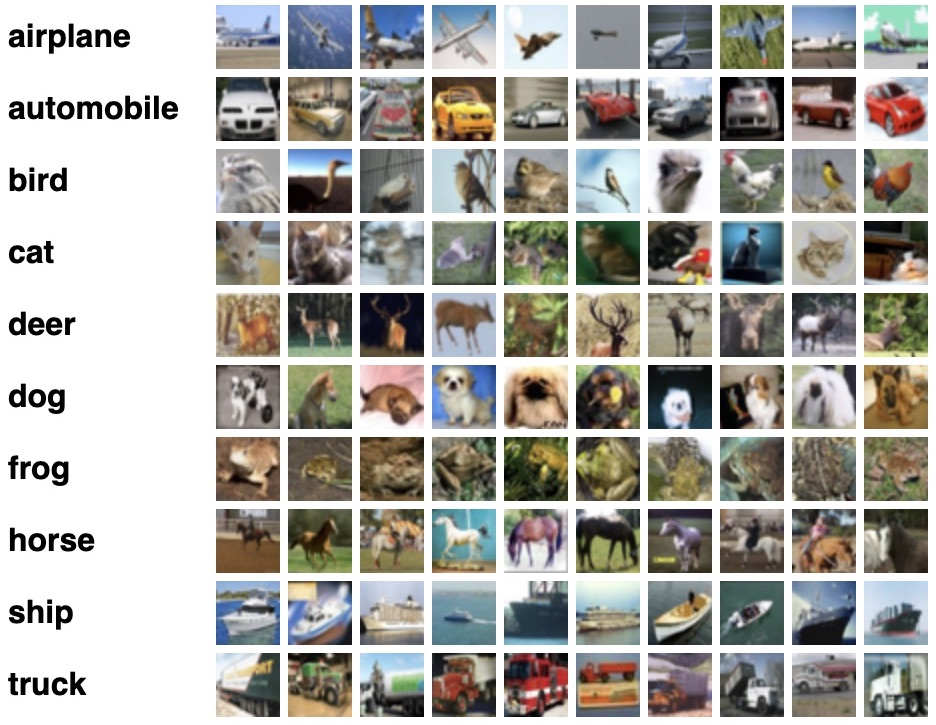

The Lightning Datamodule has 3 dataloaders, train, val, test

In [ ]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.')

Now we train!

In [ ]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=15, progress_bar_refresh_rate=10)
trainer.fit(vae, datamodule)

Global seed set to 1234
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


## Plot an image

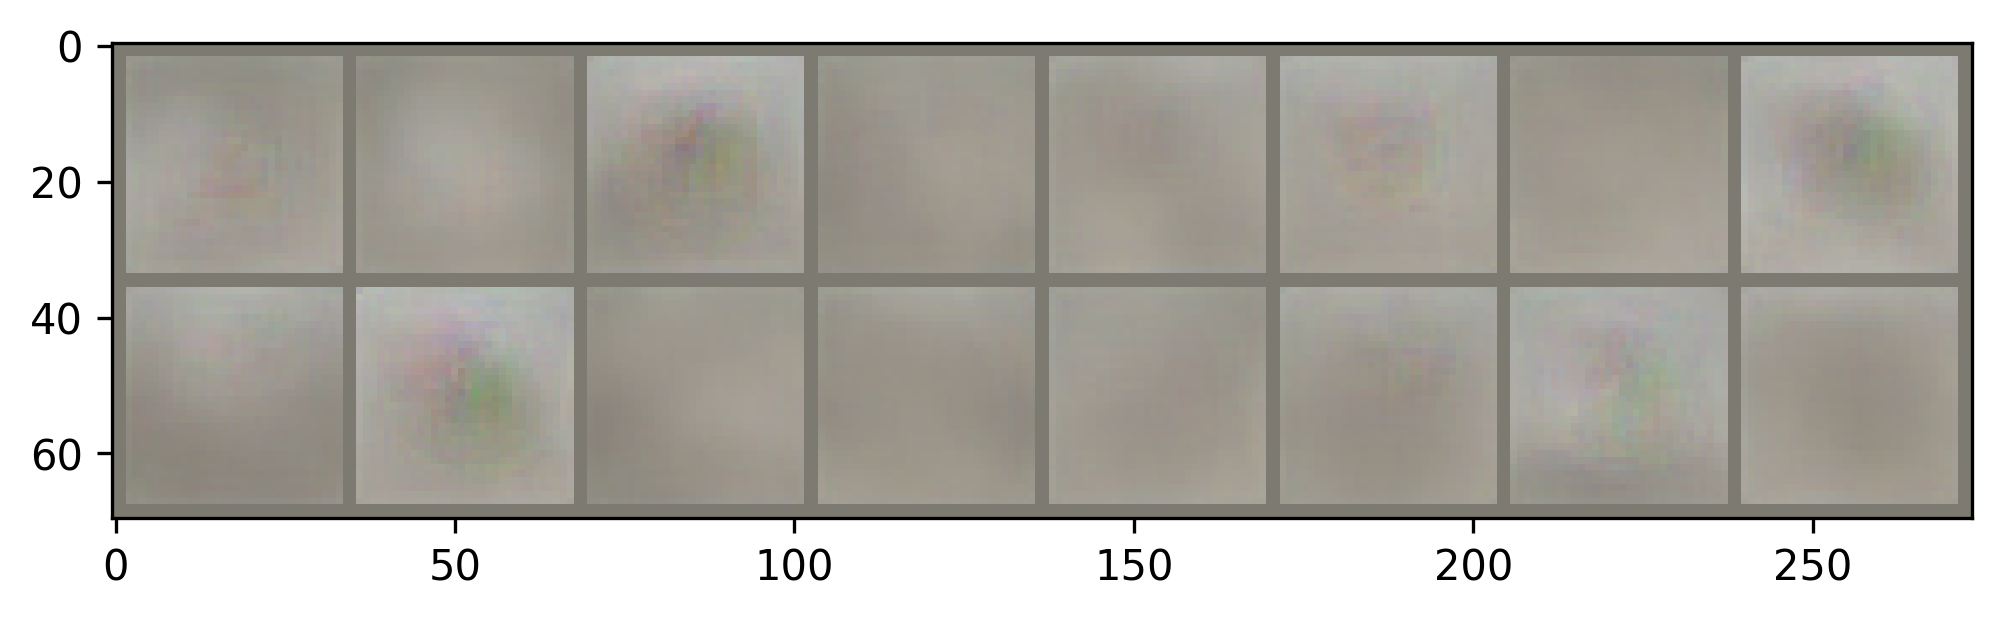

In [ ]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);

Adapted from William Falcon's code. Github link [here](https://github.com/williamFalcon/pytorch-lightning-vae). 